<a href="https://colab.research.google.com/github/hellocybernetics/Tensorflow-Probability-Tutorials/blob/master/basic_tensorflow_distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
tfd = tfp.distributions
tfb = tfp.bijectors
tf.enable_eager_execution()

### 正規分布
$$
\begin{align}
\mathcal N(x\mid \mu, \sigma) &= Z^{-1} \exp \left( -\frac{ (x - \mu)^2} {2 \sigma^2}\right) \\\
Z &= \sqrt{2 \pi \sigma^2}
\end{align}
$$

In [0]:
normal = tfd.Normal(loc=0, scale=1.0)

#### 標準正規分布からのサンプリング
$\mu = 0, \sigma=1$の場合を標準正規分布と呼ぶ。
データを実際に1000個サンプリングして、プロットしてみる。

$$
x \sim \mathcal N(x\mid 0,1) 
$$

(array([  4.,  14.,  23.,  30.,  79., 134., 159., 181., 147., 118.,  60.,
         29.,  11.,   6.,   5.]),
 array([-3.13001657, -2.70420047, -2.27838438, -1.85256829, -1.4267522 ,
        -1.00093611, -0.57512002, -0.14930393,  0.27651216,  0.70232825,
         1.12814434,  1.55396043,  1.97977653,  2.40559262,  2.83140871,
         3.2572248 ]),
 <a list of 15 Patch objects>)

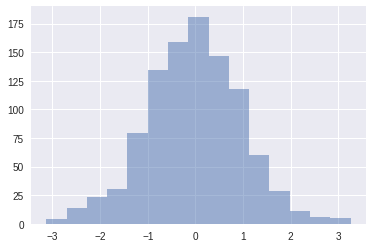

In [21]:
samples = normal.sample(1000)
plt.hist(samples.numpy(), bins=15, alpha=0.5)

#### 尤度の計算
サンプリングされた実現値 $x_i$ の尤度 ${\rm likelihood}(x_i, \mu, \sigma)$ は下記の式で計算できる。

$$
\begin{align}
{\rm likelihood}(x_i, \mu, \sigma)& =  \mathcal N(x_i∣\mu ,\sigma) \\
& =\frac{1}{\sqrt{2\pi \sigma^2}} \exp \left(−\frac{(x_i - \mu)^2}{2\sigma^2}\right)
\end{align}
$$

これは単に正規分布の式に$x_i$を代入しているだけである。これで、$x_i$が実現して手元に手に入る確率が計算される。仮に N個のサンプル $D =\{x_1, \cdots, x_N\} $ を観測したのであれば、$D$ 全体の尤度 ${\rm likelihood} (D)$は、それぞれのデータの尤度の積である。

$$
\begin{align}
{\rm likelihood}(D, \mu, \sigma)& = \prod_{i=1}^N \mathcal N(x_i∣\mu, \sigma) \\
& =\prod_{i=1}^N \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left(−\frac{(x_i-\mu)^2}{2\sigma^2}\right)
\end{align}
$$

こうしていいのは、各々のデータ $x_i $は互いに独立であると考えているためである。通常の場合 $D$ をよく表すような確率分布を決めるために $\mu, \sigma$を求めることを推定と呼ぶ。尤度が大きくなるような $\mu, \sigma$ を選ぶことができたら、$ D $ を出現させる確率が高い確率分布を（正規分布の中から）見つけたと言える。

これを最尤推定と呼ぶ。尤度を $D$ を既知として固定し、$\mu, \sigma$を変えることで最大化するわけだが、$\prod_{i=1}^N$がなかなか曲者に見える。


#### 対数尤度
そこで最大化では通常、対数尤度と呼ばれる下記の式を代わりに使う。

$$
{\rm log\ likelihood}(D, \mu, \sigma)
=-\frac{N}{2}\log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^N (x_i-\mu)^2  
$$

単に尤度の対数を取っただけである。対数を取ると「掛け算は足し算」、「割り算は引き算」、「累乗は掛け算」になることを使えば簡単に上記の式が出てくる。

In [22]:
likelihood = normal.log_prob(samples)
print("log likelihood of each data \n", likelihood.numpy()[0:10])
print("log likelihood of whole data \n", likelihood.numpy().sum())

log likelihood of each data 
 [-0.98887724 -0.9246708  -0.94481987 -0.95089626 -1.073565   -4.172094
 -0.98895293 -1.8417324  -1.350993   -0.93244195]
log likelihood of whole data 
 -1413.1373


#### TensorFlow Probabilityで最尤推定実践

(array([ 1.,  0.,  3.,  9., 23., 25., 56., 52., 50., 36., 27.,  8.,  8.,
         0.,  2.]),
 array([-3.41854715, -2.50274626, -1.58694537, -0.67114449,  0.2446564 ,
         1.16045729,  2.07625818,  2.99205907,  3.90785996,  4.82366085,
         5.73946174,  6.65526263,  7.57106352,  8.48686441,  9.4026653 ,
        10.31846619]),
 <a list of 15 Patch objects>)

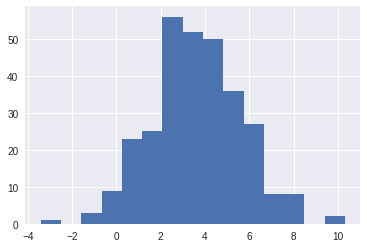

In [46]:
real_data = tfd.Normal(loc=3.5, scale=2.0).sample(300)
plt.hist(real_data, bins=15)

In [0]:
mu = tf.Variable(0.)
sigma = tf.Variable(1.)

def log_likelihood(obs_data, variable_loc, variable_scale):
    model_dist = tfd.Normal(loc=variable_loc, scale=variable_scale)
    return tf.reduce_sum(model_dist.log_prob(obs_data))

loss = lambda mu, sigma: - log_likelihood(obs_data=real_data, 
                                          variable_loc=mu, 
                                          variable_scale=sigma)

In [48]:
optimizer = tf.train.AdamOptimizer()
value_and_grads = tf.contrib.eager.implicit_value_and_gradients(loss)

for i in range(10000):
    loss, grads = value_and_grads(mu, sigma)
    optimizer.apply_gradients(grads)
    
    if i % 1000 == 0:
        print("likelihood ", - loss.numpy())

likelihood  -2837.9133
likelihood  -1132.6304
likelihood  -852.5217
likelihood  -743.1271
likelihood  -689.1488
likelihood  -659.8075
likelihood  -644.32605
likelihood  -638.95447
likelihood  -638.3823
likelihood  -638.37445


In [0]:
trained_dist = tfd.Normal(loc=mu, scale=sigma)
trained_sample = trained_dist.sample(300)

(array([ 4.,  3.,  5., 18., 34., 37., 35., 53., 40., 28., 19., 16.,  4.,
         3.,  1.]),
 array([-1.90442777, -1.13670715, -0.36898653,  0.39873409,  1.16645471,
         1.93417533,  2.70189595,  3.46961657,  4.23733719,  5.00505781,
         5.77277843,  6.54049905,  7.30821967,  8.07594029,  8.84366091,
         9.61138153]),
 <a list of 15 Patch objects>)

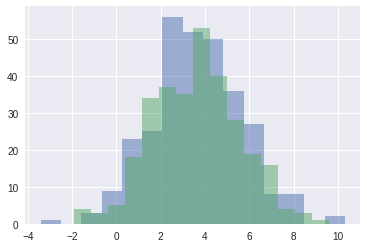

In [51]:
plt.hist(real_data, bins=15, alpha=0.5)
plt.hist(trained_sample, bins=15, alpha=0.5)